# Calculate PV Friction Flux Terms

I think this doesn't work correctly because the PV flux terms are averaged over a day, whereas the history terms are instantaneous. This shows up as an issue in the u_rhs terms, as that is the direction of mean flow, so the averages don't correspond well with the instanteous buoyancy gradients in y (I think). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from dask.distributed import Client
import dask
import xarray as xr
import xgcm
from dask.diagnostics import ProgressBar
import sys
import matplotlib.patches as patches
sys.path.append('/homes/metofac/wenegrat/xroms/')
sys.path.append('/homes/metofac/wenegrat/pyspec/')

#from xroms import open_roms_netcdf_dataset
import cmocean.cm as cmo
import xroms
from pyspec import spectrum as spec
from scipy import integrate as integrate
from timeit import default_timer as timer

#%%
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 14
plt.rcParams['contour.negative_linestyle'] = 'solid'

import sys
sys.path.append("../src/")
import load_model_runs as lruns

from importlib import reload  
import time

/homes/metofac/wenegrat/xroms/xroms/interp.py:18: UserWarning: xESMF is not installed, so `interpll` will not run.
  warnings.warn("xESMF is not installed, so `interpll` will not run.")


In [2]:
client = Client(processes=False)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://128.8.216.13:8787/status,
Dashboard: http://128.8.216.13:8787/status,Workers: 1
Total threads: 128,Total memory: 502.98 GiB
Status: running,Using processes: False
Comm: inproc://128.8.216.13/3109901/1,Workers: 1
Dashboard: http://128.8.216.13:8787/status,Total threads: 128
Started: Just now,Total memory: 502.98 GiB
Comm: inproc://128.8.216.13/3109901/4,Total threads: 128
Dashboard: http://128.8.216.13:42497/status,Memory: 502.98 GiB
Nanny: None,


In [3]:
def loadPV(filename, chunks='auto', avg=False):
    # note here that filename should be the directory of history files
    from glob import glob

    print(filename)
    if avg:
        files = sorted(glob(filename+'jet_avg.*.nc'))
    else:
        files = sorted(glob(filename+'jet_his*.nc'))
    dsWC = xr.open_mfdataset(files, combine='nested', concat_dim='time', data_vars='minimal', chunks=chunks, coords='minimal', compat='override', parallel=True, engine='h5netcdf')

    dsWC, grid = xroms.roms_dataset(dsWC, Vtransform=1) ### IS THIS CORRECT???? NEED TO VERIFY!!
    dsWC['rho'] = dsWC.temp
    dsWC = dsWC.swap_dims({'time':'ocean_time'})
    dsWC['temp'] = (-(1000+dsWC.rho)/(1000+dsWC.rho.isel(ocean_time=1, s_rho=-1).mean()) + 1)/2e-4 + 20
    return dsWC, grid

In [5]:
## LOAD THE NEW RUNS
chunks={'time':1}

reload(lruns)
#dsWC, gridWC = lruns.loadRun('../data/model/JET_ML_CFB/', chunks={'time':1}, old=False, avg=False)
dsWC, gridWC = lruns.newLoad('../data/model/JET_NML_CFB_BFLUX/', chunks=chunks)
dsWC_f = dsWC
dsWC = dsWC.isel(s_rho=-1)
#dsWC['f'] = dsOLD.f

reload(lruns)
# dsNC, gridNC = lruns.loadRun('../data/model/JET_ML_NOCFB/', chunks={'time':1}, old=False, avg=False)
dsNC, gridNC = lruns.newLoad('../data/model/JET_NML_NOCFB_BFLUX/', chunks=chunks)
dsNC = dsNC.isel(s_rho=-1)


In [6]:
# Calculate EBF fields
wmag = np.sqrt(2)*5
bx = xroms.to_rho(-9.8/1020*gridWC.derivative(dsWC.rho, 'X'), gridWC)
by = xroms.to_rho(-9.8/1020*gridWC.derivative(dsWC.rho, 'Y'), gridWC)
dsWC['bx'] = bx
dsWC['by'] = by
dsWC['EBF'] = ((bx*xroms.to_rho(dsWC.svstr, gridWC) - by*xroms.to_rho(dsWC.sustr, gridWC))/(dsWC.f*1020)).compute()
dsWC['EBFm'] = (bx*1e-3*wmag*5 - by*1e-3*wmag*5)/(dsWC.f*1020)
dsWC['Nablab'] = np.sqrt(bx**2 + by**2)
dsWC['EBFp'] = dsWC.EBF-dsWC.EBFm


bx = xroms.to_rho(-9.8/1020*gridNC.derivative(dsNC.rho, 'X'), gridNC)
by = xroms.to_rho(-9.8/1020*gridNC.derivative(dsNC.rho, 'Y'), gridNC)
dsNC['bx'] = bx
dsNC['by'] = by

In [7]:
#calculate vorticity fields
vx = gridWC.derivative(dsWC.v, 'X')
uy = gridWC.derivative(dsWC.u, 'Y')
dsWC['vort'] = xroms.to_rho(vx - uy, gridWC) #psi points
dsWC['absvort'] = (dsWC.vort + dsWC.f).compute()

vx = gridNC.derivative(dsNC.v, 'X')
uy = gridNC.derivative(dsNC.u, 'Y')
dsNC['vort'] = xroms.to_rho(vx - uy, gridNC) #psi points
dsNC['absvort'] = (dsNC.vort + dsNC.f).compute()

In [12]:
# Load the PV Flux terms

runname = 'JET_NML_CFB_BFLUX'
dsWC_PV = xr.open_mfdataset('../data/model/'+runname+'/jet_pv*.nc', combine='nested', concat_dim='time', data_vars='minimal', chunks=chunks, coords='minimal', compat='override', parallel=True)
dsWC_PV = dsWC_PV.swap_dims({'time':'ocean_time'})
dsWC_PV = dsWC_PV.isel(s_rho=-1)
# dsWC_PV = dsWC_PV.interp(ocean_time=dsWC.ocean_time)

runname = 'JET_NML_NOCFB_BFLUX'
dsNC_PV = xr.open_mfdataset('../data/model/'+runname+'/jet_pv*.nc', combine='nested', concat_dim='time', data_vars='minimal', chunks=chunks, coords='minimal', compat='override', parallel=True)
dsNC_PV = dsNC_PV.swap_dims({'time':'ocean_time'})
dsNC_PV = dsNC_PV.isel(s_rho=-1)
# dsNC_PV = dsNC_PV.interp(ocean_time=dsNC.ocean_time)
dsNC_PV

<xarray.Dataset>
Dimensions:     (ocean_time: 45, auxil: 4, eta_rho: 4002, xi_rho: 1002,
                 xi_u: 1001, eta_v: 4001)
Coordinates:
  * ocean_time  (ocean_time) float32 3.115e+07 3.123e+07 ... 3.486e+07 3.495e+07
    time        (ocean_time) float32 3.119e+07 3.128e+07 ... 3.491e+07 3.499e+07
Dimensions without coordinates: auxil, eta_rho, xi_rho, xi_u, eta_v
Data variables:
    time_step   (ocean_time, auxil) int32 dask.array<chunksize=(1, 4), meta=np.ndarray>
    temp_rhs    (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 4002, 1002), meta=np.ndarray>
    u_rhs       (ocean_time, eta_rho, xi_u) float32 dask.array<chunksize=(1, 4002, 1001), meta=np.ndarray>
    v_rhs       (ocean_time, eta_v, xi_rho) float32 dask.array<chunksize=(1, 4001, 1002), meta=np.ndarray>
Attributes: (12/54)
    title:         JET Example (use make_jet.m for non ANA_JET config)
    date:          
    rst_file:      jet_rst.nc
    his_file:      jet_his.00000.nc
    avg_file:      jet_avg.nc
    theta_s:       5.0
    ...            ...
    Scoef_expl:    Saline contraction coefficient
    Scoef_units:   kg.m-3.psu-1
    gamma2:        1.0
    gamma2_expl:   Slipperiness parameter
    SRCS:          main.F step.F read_inp.F timers_roms.F init_scalars.F init...
    CPP-options:   JET MPI NC4PAR SOLVE3D UV_COR UV_ADV UV_HADV_UP3 UV_VIS2 U...

## Calculate the PV flux

In [48]:
g = 9.8
rho0 = 1024

b_x = dsWC['bx']
b_y = dsWC['by']
FRIC_WC = b_x.interp(ocean_time=dsWC_PV.ocean_time)*xroms.to_rho(dsWC_PV.v_rhs, gridWC) - b_y.interp(ocean_time=dsWC_PV.ocean_time)*xroms.to_rho(dsWC_PV.u_rhs, gridWC)
#FRIC_WC = FRIC_WC.isel(s_rho=-1)

b_x = dsNC['bx']
b_y = dsNC['by']
FRIC_NC = b_x.interp(ocean_time=dsNC_PV.ocean_time)*xroms.to_rho(dsNC_PV.v_rhs, gridNC) - b_y.interp(ocean_time=dsNC_PV.ocean_time)*xroms.to_rho(dsNC_PV.u_rhs, gridNC)
#FRIC_NC = FRIC_NC.isel(s_rho=-1)

FRIC_NC 

<xarray.DataArray (ocean_time: 45, eta_rho: 4002, xi_rho: 1002)>
dask.array<sub, shape=(45, 4002, 1002), dtype=float32, chunksize=(1, 4002, 1002), chunktype=numpy.ndarray>
Coordinates:
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
    s_rho       float32 -0.005
    x_rho       (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
    y_rho       (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
    time        (ocean_time) float64 3.115e+07 3.123e+07 ... 3.486e+07 3.495e+07
    z_rho       (ocean_time, eta_rho, xi_rho) float64 -1.044 -1.044 ... -2.832
    z_rho0      (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
  * ocean_time  (ocean_time) float32 3.115e+07 3.123e+07 ... 3.486e+07 3.495e+07

In [52]:
FRIC_NC[10, 1000, 100].values

array(6.344689e-14)

In [329]:
dst

<xarray.Dataset>
Dimensions:     (ocean_time: 45, auxil: 4, s_rho: 100, eta_rho: 4002,
                 xi_rho: 1002, xi_u: 1001, eta_v: 4001)
Coordinates:
  * ocean_time  (ocean_time) float32 3.115e+07 3.123e+07 ... 3.486e+07 3.495e+07
    time        (ocean_time) float64 3.119e+07 3.128e+07 ... 3.491e+07 3.499e+07
Dimensions without coordinates: auxil, s_rho, eta_rho, xi_rho, xi_u, eta_v
Data variables:
    time_step   (ocean_time, auxil) int32 dask.array<chunksize=(1, 4), meta=np.ndarray>
    temp_rhs    (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 100, 4002, 1002), meta=np.ndarray>
    u_rhs       (ocean_time, s_rho, eta_rho, xi_u) float32 dask.array<chunksize=(1, 100, 4002, 1001), meta=np.ndarray>
    v_rhs       (ocean_time, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(1, 100, 4001, 1002), meta=np.ndarray>
Attributes: (12/54)
    title:         JET Example (use make_jet.m for non ANA_JET config)
    date:          
    rst_file:      jet_rst.nc
    his_file:      jet_his.00000.nc
    avg_file:      jet_avg.nc
    theta_s:       5.0
    ...            ...
    Scoef_expl:    Saline contraction coefficient
    Scoef_units:   kg.m-3.psu-1
    gamma2:        1.0
    gamma2_expl:   Slipperiness parameter
    SRCS:          main.F step.F read_inp.F timers_roms.F init_scalars.F init...
    CPP-options:   JET MPI NC4PAR SOLVE3D UV_COR UV_ADV UV_HADV_UP3 UV_VIS2 U...

In [14]:
# Calculate the diabatic flux
g = 9.8
rho0 = 1024

b_rhs = -g/rho0*dsWC_PV.temp_rhs # noting that temp = rho in the sim

DIA_WC = -dsWC.absvort.interp(ocean_time=b_rhs.ocean_time)*b_rhs



b_rhs = -g/rho0*dsNC_PV.temp_rhs # noting that temp = rho in the sim

DIA_NC = -dsNC.absvort.interp(ocean_time=b_rhs.ocean_time)*b_rhs

In [53]:
# Integrate over frontal region and plot time series

yl = slice(1000, 3002)
INTFRIC_WC = FRIC_WC.isel(eta_rho=yl).sum(('eta_rho', 'xi_rho')).compute()
INTFRIC_NC = FRIC_NC.isel(eta_rho=yl).sum(('eta_rho', 'xi_rho')).compute()



Task exception was never retrieved
future: <Task finished name='Task-596520' coro=<Client._gather.<locals>.wait() done, defined at /homes/metofac/wenegrat/.conda/envs/CFB_EBF_3/lib/python3.10/site-packages/distributed/client.py:2122> exception=AllExit()>
Traceback (most recent call last):
  File "/homes/metofac/wenegrat/.conda/envs/CFB_EBF_3/lib/python3.10/site-packages/distributed/client.py", line 2131, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-596521' coro=<Client._gather.<locals>.wait() done, defined at /homes/metofac/wenegrat/.conda/envs/CFB_EBF_3/lib/python3.10/site-packages/distributed/client.py:2122> exception=AllExit()>
Traceback (most recent call last):
  File "/homes/metofac/wenegrat/.conda/envs/CFB_EBF_3/lib/python3.10/site-packages/distributed/client.py", line 2131, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-59652

In [16]:
yl = slice(1000, 3002)
INTDIA_WC = DIA_WC.isel(eta_rho=yl).sum(('eta_rho', 'xi_rho')).compute()

INTDIA_NC = DIA_NC.isel(eta_rho=yl).sum(('eta_rho', 'xi_rho')).compute()

    


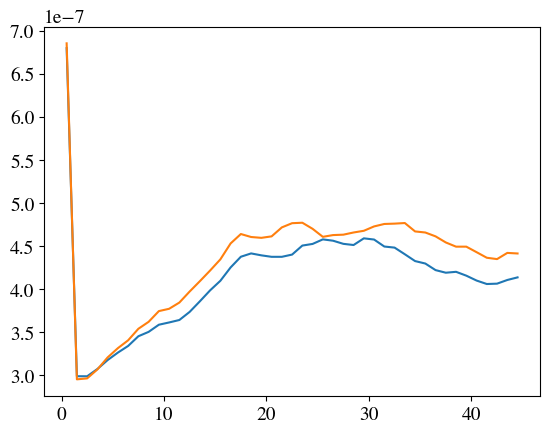

In [17]:
plt.plot(INTDIA_WC.ocean_time/86400-360, INTDIA_WC, label='DIA_WC')
plt.plot(INTDIA_NC.ocean_time/86400-360, INTDIA_NC, label='DIA_NC')

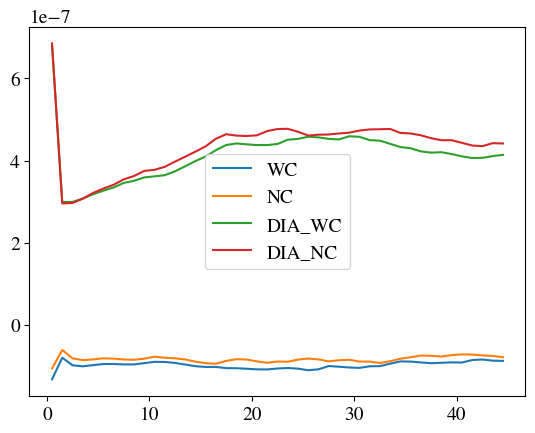

In [54]:
plt.plot(INTFRIC_WC.ocean_time/86400-360, INTFRIC_WC, label='WC')
plt.plot(INTFRIC_NC.ocean_time/86400-360, INTFRIC_NC, label='NC')
plt.plot(INTDIA_WC.ocean_time/86400-360, INTDIA_WC, label='DIA_WC')
plt.plot(INTDIA_NC.ocean_time/86400-360, INTDIA_NC, label='DIA_NC')

plt.legend()

In [65]:
# integrate in time
INTFRIC_WC_I  = integrate.cumtrapz(INTFRIC_WC, x=FRIC_WC.ocean_time, initial=0)
INTFRIC_NC_I  = integrate.cumtrapz(INTFRIC_NC, x=FRIC_NC.ocean_time, initial=0)

INTDIA_WC_I  = integrate.cumtrapz(INTDIA_WC, x=DIA_WC.ocean_time, initial=0)
INTDIA_NC_I  = integrate.cumtrapz(INTDIA_NC, x=DIA_NC.ocean_time, initial=0)

In [47]:
# load the PV
dsPV = xr.open_dataset('../data/interim/pvintegrated_500depth_FZ_bflux.nc', engine='netcdf4')
# dsPV = xr.open_dataset('../data/interim/pvintegrated_500depth_bflux.nc', engine='netcdf4')

dsPV

<xarray.Dataset>
Dimensions:  (time: 31)
Coordinates:
  * time     (time) float64 3.11e+07 3.119e+07 3.128e+07 ... 3.361e+07 3.37e+07
Data variables:
    pv_wc    (time) float64 ...
    pv_nc    (time) float64 ...
Attributes:
    type:     noflux
    yl_l:     1000
    yl_r:     3002

In [30]:
dsWC_f.z_rho0.isel(s_rho=slice(43,100))[:,0,0].values

array([-498.03333825, -475.34357566, -453.70364732, -433.06195673,
       -413.36931378, -394.57904559, -376.64669365, -359.52985668,
       -343.18824655, -327.58350733, -312.67916623, -298.44037601,
       -284.83407767, -271.82873654, -259.39432706, -247.50226761,
       -236.12533833, -225.23756047, -214.81423475, -204.83177131,
       -195.26774774, -186.10070737, -177.31024449, -168.8768823 ,
       -160.78203532, -153.00796882, -145.53773443, -138.35514241,
       -131.44474884, -124.79177763, -118.38208479, -112.2021378 ,
       -106.23899807, -100.48024899,  -94.91398992,  -89.52880443,
        -84.31371705,  -79.25820768,  -74.3521238 ,  -69.58569557,
        -64.94951226,  -60.43447354,  -56.03179951,  -51.73297056,
        -47.52974931,  -43.41411522,  -39.37828986,  -35.41467226,
        -31.5158547 ,  -27.67458818,  -23.88376804,  -20.13641738,
        -16.42566493,  -12.7447337 ,   -9.08691876,   -5.44557478,
         -1.81409617])

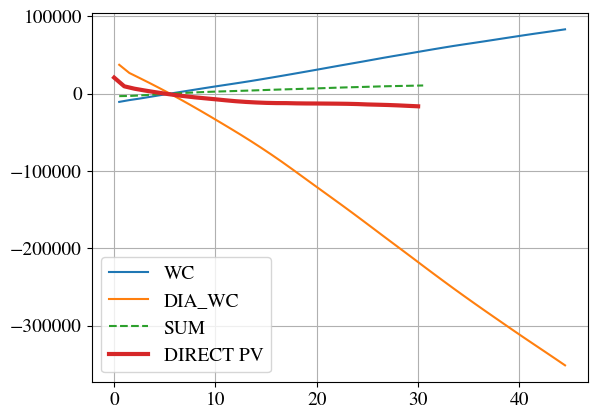

In [77]:
# time cumulative of PV terms for the WC run

sum_WC = -INTFRIC_WC_I[0:31] - INTDIA_WC_I[0:31]

plt.plot(FRIC_WC.ocean_time/86400 - 360, -(INTFRIC_WC_I-INTFRIC_WC_I[5])*(500**2), label='WC')
# plt.plot(FRIC_NC.ocean_time, -(INTFRIC_NC_I-INTFRIC_NC_I[5])*(500**2), label='NC')
plt.plot(DIA_WC.ocean_time/86400 - 360, -(INTDIA_WC_I-INTDIA_WC_I[5])*(500**2), label='DIA_WC')
plt.plot(FRIC_WC.ocean_time[0:31]/86400 - 360, (sum_WC - sum_WC[5])*(500**2), label='SUM', linestyle='--')

# plt.plot(FRIC_WC.ocean_time, -9.8/1024*(VOLPV-VOLPV[5]), linestyle=':', label='MOREL PV')

plt.plot(dsPV.time/86400-360, (dsPV.pv_wc - dsPV.pv_wc[5]), linewidth=3, label='DIRECT PV')
#plt.plot(dsPV.time/86400-360, (dsPV.pv_nc - dsPV.pv_nc[5]))
plt.legend()
# plt.xlim(5, 30)
plt.grid()

In [119]:
drho = dst.rho - dst.rho.isel(s_rho=-1)

thresh = xr.where((np.abs(drho) > 0.03) , dst.z_rho, np.nan)
mldi = thresh.max("s_rho").compute()

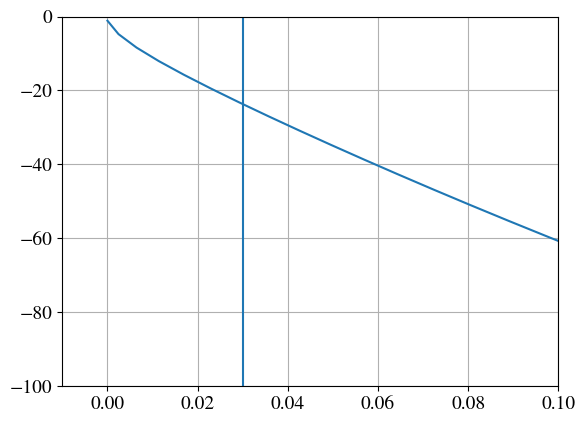

In [158]:
plt.plot( drho.isel(ocean_time=0, eta_rho=1000, xi_rho=0), dst.z_rho.isel(ocean_time=0, eta_rho=1000, xi_rho=0))
plt.ylim(-100, 0)
plt.xlim(-0.01, 0.1)
plt.axvline(0.03)
plt.grid()

In [227]:
de = np.sqrt(np.sqrt(xroms.to_rho(dsWC.svstr, gridWC)**2 + xroms.to_rho(dsWC.sustr, gridWC)**2)/1024)/dsWC.f
de = de.compute()
de

<xarray.DataArray (ocean_time: 46, eta_rho: 4002, xi_rho: 1002)>
array([[[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        ...,
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ]],

       [[82.256424, 82.256424, 82.25641 , ..., 82.25643 , 82.256424,
         82.256424],
        [82.22543 , 82.225426, 82.22542 , ..., 82.22543 , 82.22543 ,
         82.22543 ],
        [82.2743  , 82.2743  , 82.2743  , ..., 82.2743  , 82.2743  ,
         82.2743  ],
...
        [58.426197, 58.531487, 58.735596, ..., 58.282   , 58.384544,
         58.442554],
        [59.0037  , 58.989872, 58.896515, ..., 58.73807 , 58.96528 ,
         59.012196],
        [58.983616, 59.003918, 58.963184, ..., 58.68626 , 58.937645,
         59.01597 ]],

       [[79.30334 , 79.35938 , 79.449005, ..., 79.1993  , 79.27236 ,
         79.32682 ],
        [79.23777 , 79.23628 , 79.29438 , ..., 79.19743 , 79.20673 ,
         79.20358 ],
        [78.99406 , 78.92046 , 78.91943 , ..., 79.08641 , 78.99021 ,
         78.89247 ],
        ...,
        [59.494976, 59.441723, 59.357174, ..., 59.58604 , 59.518044,
         59.46791 ],
        [59.66054 , 59.62304 , 59.55838 , ..., 59.72096 , 59.677715,
         59.644325],
        [59.690773, 59.661015, 59.606358, ..., 59.74019 , 59.706078,
         59.680313]]], dtype=float32)
Coordinates:
  * xi_rho   (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
  * eta_rho  (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
    s_rho    float32 -0.005
    x_rho    (eta_rho, xi_rho) float32 -250.0 250.0 ... 4.998e+05 5.002e+05
    y_rho    (eta_rho, xi_rho) float32 -250.0 -250.0 -250.0 ... 2e+06 2e+06
    z_rho0   (eta_rho, xi_rho) float32 -1.814 -1.814 -1.814 ... -1.814 -1.814
Dimensions without coordinates: ocean_time

In [237]:
# calculate the scaling
# drho = dsWC.rho - dsWC.rho.isel(s_rho=-1)
yl = slice(1000, 3002)

startdate=1
hbl = dsWC.hbl.copy() #+ 5
hbl = np.abs(mldi) 
# hbl = de*0.4
# hbl = hbl.where(hbl>3.76*3, drop=True)
Jf = dsWC.absvort*dsWC.EBFp/hbl
Jf = dsWC.f*dsWC.EBFp/hbl
# Jf = dsWC.f*dsWC.EBFp*(1/hbl).mean(('eta_rho', 'xi_rho'))

# Jf = dsWC.f*dsWC.EBFp/60
Jf_A = Jf.isel(eta_rho=yl).sum(('eta_rho', 'xi_rho'))
Jf_A_t = integrate.cumtrapz(Jf_A[startdate:], x = Jf_A.ocean_time[startdate:], initial=0) 
    

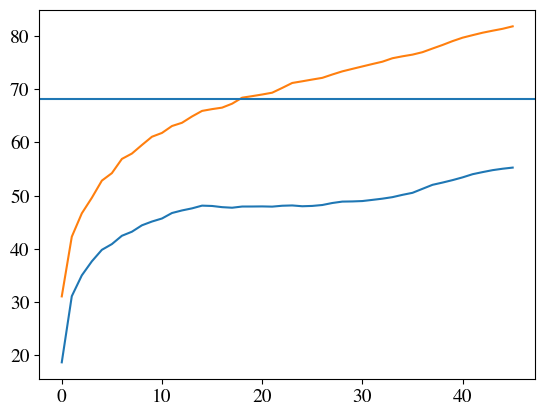

In [239]:
plt.plot(1/(1/hbl).mean(('xi_rho', 'eta_rho')))
plt.plot(hbl.mean(('xi_rho', 'eta_rho')))
plt.axhline(de.mean())


In [248]:
print(hbl.isel(eta_rho=yl).mean())

<xarray.DataArray 'rho' ()>
array(45.05522, dtype=float32)
Attributes:
    long_name:  depth of RHO-points
    time:       ocean_time
    field:      z_rho, scalar, series
    units:      m
    positive:   up


In [249]:
1e-4*(5/btowatts)/hbl.isel(eta_rho=yl).mean() * (86400*30)/500

<xarray.DataArray 'rho' ()>
array(2.7636674e-11)
Attributes:
    long_name:  depth of RHO-points
    time:       ocean_time
    field:      z_rho, scalar, series
    units:      m
    positive:   up

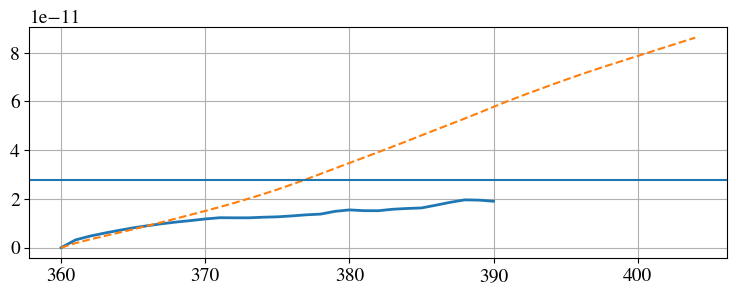

In [251]:
norm = 500*1000e3*500e3
startdate=0
deltaPV = dsPV.pv_wc-dsPV.pv_nc

plt.figure(figsize=(9,3))
plt.plot(dsPV.time/86400, (deltaPV-deltaPV[startdate])/norm, linewidth=2, label='Delta PV')

plt.plot(Jf_A.ocean_time[0:-1]/86400, -Jf_A_t*500**2/norm, linestyle='--',label='Scaling')
# plt.ylim(0, 2.5e-11)
plt.grid()

plt.axhline(1e-4*(5/btowatts)/hbl.isel(eta_rho=yl).mean() * (86400*30)/500)

<xarray.DataArray ()>
array(1.96115897e-11)


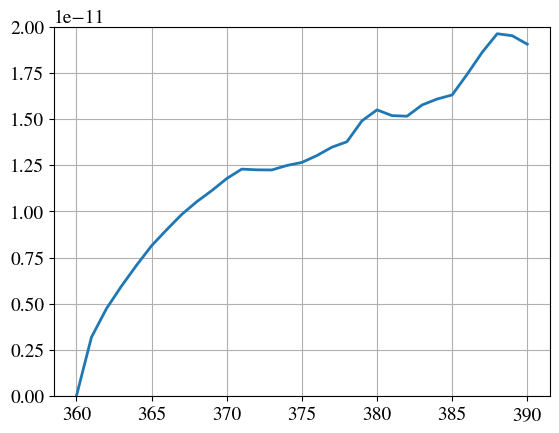

In [81]:
dsPV = xr.open_dataset('../data/interim/pvintegrated_500depth_FZ_bflux.nc', engine='netcdf4')
startdate=0
deltaPV = dsPV.pv_wc - dsPV.pv_nc
plt.plot(dsPV.time/86400, (deltaPV)/norm, linewidth=2, label='Delta PV')
plt.grid()
plt.ylim(0, 2e-11)
print(np.max(deltaPV/norm))

NameError: name 'INTFRIC_WC_I' is not defined

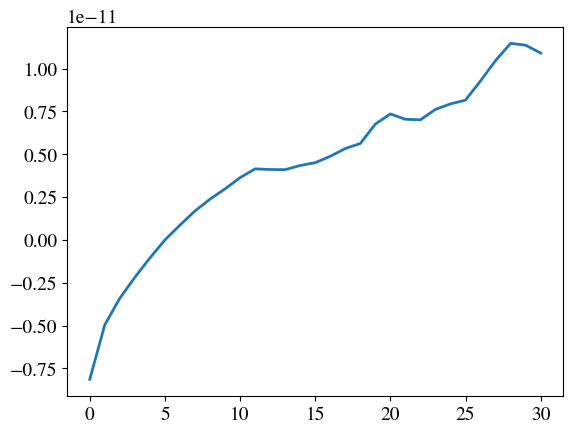

In [85]:
# Look at delta PV vs delta Fric
deltaPV = dsPV.pv_wc-dsPV.pv_nc
# delta
norm = 500*1000e3*500e3
plt.plot(dsPV.time/86400-360, (deltaPV-deltaPV[5])/norm, linewidth=2, label='Delta PV')
deltaFric = INTFRIC_WC_I[0:31] - INTFRIC_NC_I[0:31]
plt.plot(dsPV.time/86400-360, -(deltaFric-deltaFric[5])*500**2/norm, label='Delta F')
plt.plot(Jf_A.ocean_time[startdate:]/86400-360, -Jf_A_t*500**2/norm, linestyle='--',label='Scaling')

deltaDia = INTDIA_WC_I[0:31] - INTDIA_NC_I[0:31]
plt.plot(dsPV.time/86400-360, -(deltaDia-deltaDia[5])*500**2/norm, label='Delta D')
plt.plot(dsPV.time/86400-360, -((deltaDia-deltaDia[5])+(deltaFric-deltaFric[5]))*500**2/norm, label='SUM')

plt.legend()
plt.xlim(0,29)

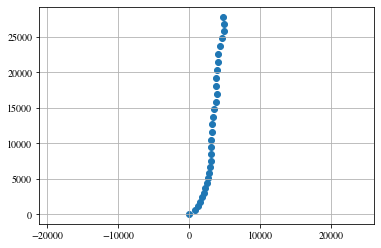

In [21]:
plt.scatter(deltaPV[0:31], -Jf_A_t[0:31]*(500**2))
plt.axis('equal')
plt.grid()

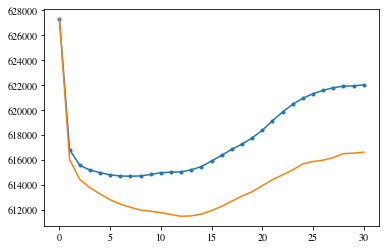

In [18]:
plt.plot(dsPV.pv_wc, marker='.')
plt.plot(dsPV.pv_nc)

(-0.01, 0.02)

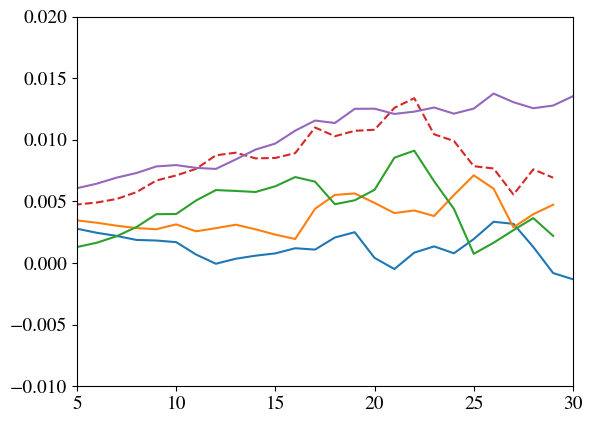

In [78]:
dPVdt = np.gradient(deltaPV)/86400
plt.plot(dPVdt)

dFricdt = INTFRIC_WC[0:30] - INTFRIC_NC[0:30]
plt.plot(-dFricdt*500**2)
dDiadt = INTDIA_WC[0:30] - INTDIA_NC[0:30]

plt.plot(-dDiadt*500**2)
plt.plot(-(dDiadt+dFricdt)*500**2, linestyle='--')
plt.plot(-Jf_A*500**2)
plt.xlim(5, 30)
plt.ylim(-0.01, 0.02)

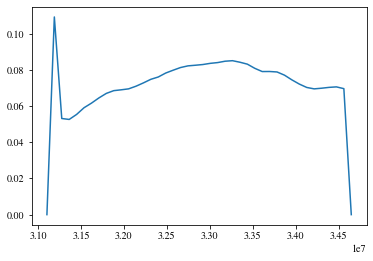

In [71]:
plt.plot(DIA_WC.ocean_time, -(INTDIA_WC)*(500**2), label='NC')


sum_WC

In [103]:
sum_WC

array([ 0.        , -0.01405517, -0.03337094, -0.04362864, -0.05417169,
       -0.06605713, -0.07922037, -0.09326387, -0.10812747, -0.12380518,
       -0.14008492, -0.15682952, -0.17406088, -0.19171922, -0.2097495 ,
       -0.22810409, -0.24690743, -0.26630123, -0.28614738, -0.30624929,
       -0.32652486, -0.34677356, -0.36698929, -0.38731967, -0.40794663,
       -0.42894483, -0.44999722, -0.47078067, -0.49112816, -0.51104386,
       -0.53080081, -0.55043221, -0.56966917, -0.58850417, -0.60685263,
       -0.62459878, -0.64189224, -0.65903354, -0.67631036, -0.69386297,
       -0.71139093, -0.72007054])

In [306]:
dsNC.dA[0,0].values/500**2

0.999999875

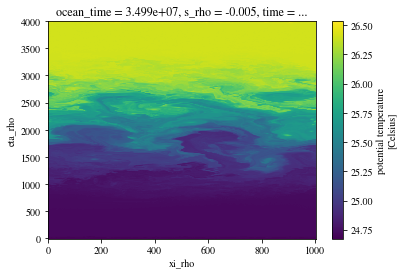

In [78]:
dsWC.rho.isel(ocean_time=-1).plot()

<xarray.DataArray (ocean_time: 46, eta_rho: 4002, xi_rho: 1002)>
dask.array<mul, shape=(46, 4002, 1002), dtype=float32, chunksize=(1, 4002, 1002), chunktype=numpy.ndarray>
Coordinates:
  * ocean_time  (ocean_time) float64 3.11e+07 3.119e+07 ... 3.491e+07 3.499e+07
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
    s_rho       float64 -0.005
    x_rho       (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
    y_rho       (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
    time        (ocean_time) float64 3.11e+07 3.119e+07 ... 3.491e+07 3.499e+07
    z_rho       (ocean_time, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 4002, 1002), meta=np.ndarray>
    z_rho0      (eta_rho, xi_rho) float64 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
Attributes:
    long_name:      potential temperature
    units:          Celsius
    field:          temperature, scalar, series
    standard_name:  sea_water_potential_temperature
    grid:           <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * c...

In [61]:
dsWC_PV

<xarray.Dataset>
Dimensions:     (ocean_time: 46, auxil: 4, eta_rho: 4002, xi_rho: 1002,
                 xi_u: 1001, eta_v: 4001)
Coordinates:
    time        (ocean_time) float64 nan 3.123e+07 3.132e+07 ... 3.495e+07 nan
  * ocean_time  (ocean_time) float64 3.11e+07 3.119e+07 ... 3.491e+07 3.499e+07
    s_rho       float64 -0.005
Dimensions without coordinates: auxil, eta_rho, xi_rho, xi_u, eta_v
Data variables:
    time_step   (ocean_time, auxil) float64 dask.array<chunksize=(46, 4), meta=np.ndarray>
    temp_rhs    (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(46, 4002, 1002), meta=np.ndarray>
    u_rhs       (ocean_time, eta_rho, xi_u) float32 dask.array<chunksize=(46, 4002, 1001), meta=np.ndarray>
    v_rhs       (ocean_time, eta_v, xi_rho) float32 dask.array<chunksize=(46, 4001, 1002), meta=np.ndarray>
Attributes: (12/54)
    title:         JET Example (use make_jet.m for non ANA_JET config)
    date:          
    rst_file:      jet_rst.nc
    his_file:      jet_his.00000.nc
    avg_file:      jet_avg.nc
    theta_s:       5.0
    ...            ...
    Scoef_expl:    Saline contraction coefficient
    Scoef_units:   kg.m-3.psu-1
    gamma2:        1.0
    gamma2_expl:   Slipperiness parameter
    SRCS:          main.F step.F read_inp.F timers_roms.F init_scalars.F init...
    CPP-options:   JET MPI NC4PAR SOLVE3D UV_COR UV_ADV UV_HADV_UP3 UV_VIS2 U...

In [77]:
dsWC_f.z_rho[0,-1,-1,0].values

array(-2.56407495)

In [81]:
dsWC_f.dz[0,-1,-1,0].values

array(3.6283326, dtype=float32)

In [90]:
dsWC_f.dz[0,-1,:,:].max().values

array(3.6296945, dtype=float32)

In [91]:
dsWC_f.dz[0,-1,:,:].min().values

array(3.6283326, dtype=float32)

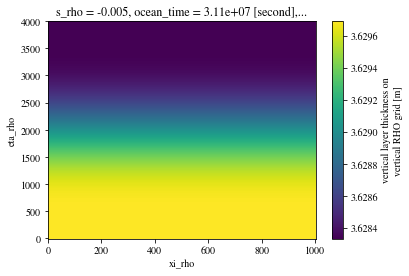

In [76]:
dsWC_f.dz[0,-1,:,:].plot()

In [76]:
reload(lruns)

dst, griddst = lruns.newLoad('../data/model/JET_NML_CFB_BFLUX/', chunks=chunks)

dst['buoyancy'] = xroms.buoyancy(dst.rho, rho0=dst.rho0)
PV = dst.isel(ocean_time=-1).xroms.ertel
PV

<xarray.DataArray 'ertel' (s_rho: 100, eta_rho: 4002, xi_rho: 1002)>
dask.array<add, shape=(100, 4002, 1002), dtype=float64, chunksize=(100, 4002, 1002), chunktype=numpy.ndarray>
Coordinates:
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
  * s_rho       (s_rho) float32 -0.995 -0.985 -0.975 ... -0.025 -0.015 -0.005
    x_rho       (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
    y_rho       (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
    ocean_time  float64 3.499e+07
    time        float64 3.499e+07
    z_rho       (s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(100, 4002, 1002), meta=np.ndarray>
    z_rho0      (s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(100, 4002, 1002), meta=np.ndarray>
Attributes:
    name:       ertel
    long_name:  ertel potential vorticity
    units:      tracer/(m*s)
    grid:       <xgcm.Grid>\nX Axis (not periodic, boundary=None):\n  * cente...

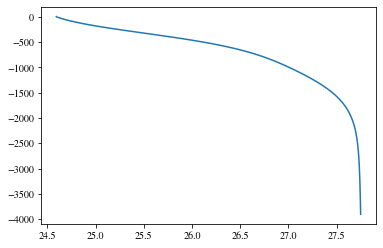

In [79]:
plt.plot(dst.rho[0,:,0,0], dst.z_rho[0,:,0,0])

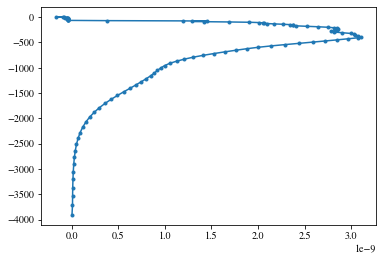

In [6]:
plt.plot(PV[:,1000,0], dst.z_rho[0,:,1000,0], marker='.')


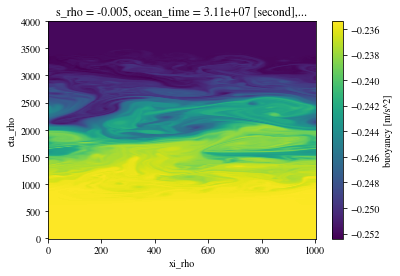

In [7]:
dst.buoyancy[0,-1,:,:].plot()

In [114]:
dsPV.pv_wc[1]

<xarray.DataArray 'pv_wc' ()>
array(627336.097444)
Coordinates:
    time     float64 3.11e+07

# OTHER FLUXES

In [25]:
chunks={'time':1}
dst.close()
dst, griddst = lruns.newLoad('../data/model/JET_NML_CFB_BFLUX/', chunks=chunks)
dst = dst.swap_dims({'ocean_time':'time'})
dst['buoyancy'] = xroms.buoyancy(dst.rho, rho0=dst.rho0)

In [27]:
#advective flux 
yn = 3002
ys = 1000
zd = 43
zl = slice(zd, 101)

vq_n = PV.isel(eta_v=yn, s_w=zl)*xroms.to_s_w(xroms.to_u(dst.v, griddst).isel(eta_rho=yn), griddst).isel(s_w=zl)

vq_s = PV.isel(eta_v=ys, s_w=zl)*xroms.to_s_w(xroms.to_u(dst.v, griddst).isel(eta_rho=ys), griddst).isel(s_w=zl)


# vq_n = vq_n*dst.dz_w_u0.isel(eta_rho=yn, s_w=zl)*dst.dx_u.isel(eta_rho=yn)
# vq_s = vq_s**dst.dz_w_u0.isel(eta_rho=ys, s_w=zl)*dst.dx_u.isel(eta_rho=ys)

vq = (vq_n - vq_s)
print('here')
vq_x = vq.sum(('xi_u')).compute()
# vq_xz = integrate.trapz(vq_x, axis=1).compute()
# adv_flux = vq_xz



here


AttributeError: 'numpy.ndarray' object has no attribute 'compute'

In [28]:
zcoords = dst.z_w0.isel(s_w=zl, eta_rho=yn)[:,0].values
vq_xz = integrate.trapz(vq_x, x=zcoords, axis=1)
adv_flux = vq_xz

In [29]:
adv_flux_i_wc = integrate.cumtrapz(adv_flux, x=dst.time, initial=0)

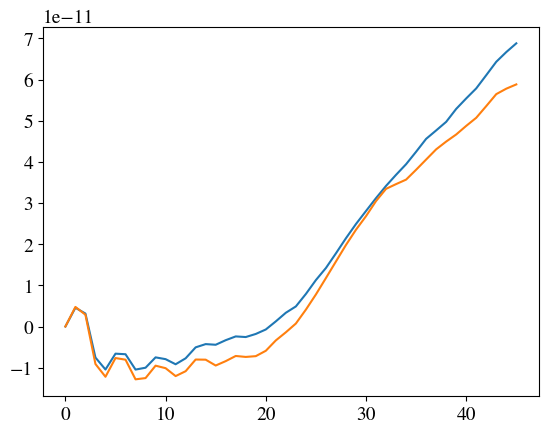

In [48]:
norm = 500*1000e3*500e3

plt.plot(dst.time/86400-360, 9.8/1024*adv_flux_i_wc*500/norm)
plt.plot(dst.time/86400-360, 9.8/1024*adv_flux_i_nc*500/norm)


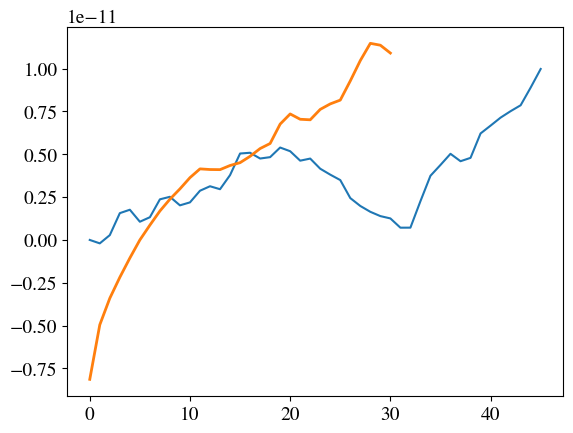

In [47]:
deltaPV = dsPV.pv_wc-dsPV.pv_nc

plt.plot(dst.time/86400 - 360, 9.8/1024*(adv_flux_i_wc - adv_flux_i_nc)*500/norm )
plt.plot(dsPV.time/86400-360, (deltaPV-deltaPV[5])/norm, linewidth=2, label='Delta PV')


In [34]:
# import h5netcdf
# horizontal frictional fluxes 
runname = 'JET_NML_CFB_BFLUX'
chunks = {'time':1}
#advective flux 
yn = 3002
ys = 1000
zd = 43
zl = slice(zd, 101)
# dst = dsWC_f
#dsWC_PV_f= xr.open_mfdataset('../data/model/'+runname+'/jet_pv*.nc', combine='nested', concat_dim='time', data_vars='minimal', chunks=chunks, coords='minimal', compat='override', parallel=False, decode_cf=False, engine='h5netcdf')
dsWC_PV_f = xr.open_mfdataset('../data/model/'+runname+'/jet_pv*.nc', combine='nested', concat_dim='time', data_vars='minimal', chunks=chunks, coords='minimal', compat='override', parallel=True, decode_cf = False)
dsWC_PV_f = dsWC_PV_f.swap_dims({'time':'ocean_time'})

# dst, griddst = lruns.newLoad('../data/model/JET_NML_CFB_BFLUX/', chunks=chunks)
# dst = dst.swap_dims({'ocean_time':'time'})
# dst['buoyancy'] = xroms.buoyancy(dst.rho, rho0=dst.rho0)

# dsWC_PV_f = dsWC_PV_f.isel(ocean_time = slice(0, 10))
# dsWC_PV_f = dsWC_PV_f.interp(ocean_time=dsWC_f.ocean_time).compute()
Fx = (dsWC_PV_f.u_rhs)
bz = xroms.N2(dsWC_f.swap_dims({'ocean_time':'time'}).rho, gridWC)

Fx = xroms.to_rho(Fx.isel(ocean_time=20), gridWC)
bz = bz.isel(time=20)


# dst['N2'] = griddst.derivative(dst.buoyancy, 'Z')
FluxN = Fx.isel(eta_rho=yn, s_rho=zl)#.compute()
FluxN = FluxN*xroms.to_s_rho(bz.isel(eta_rho=yn), gridWC).isel(s_rho=zl).compute()
FluxS = Fx.isel(eta_rho=ys, s_rho=zl).compute()
FluxS = FluxS*xroms.to_s_rho(bz.isel(eta_rho=ys), gridWC).isel(s_rho=zl).compute()

DIA_z = FluxN - FluxS

DIA_z_A = (DIA_z*dsWC_f.dz0.isel(eta_rho=ys, s_rho=zl)*dsWC_f.dx.isel(eta_rho=ys)).sum(('s_rho', 'xi_rho')).compute()
DIA_z_A


<xarray.DataArray ()>
array(2.2398312e-05, dtype=float32)
Coordinates:
    eta_rho  int64 1000

In [36]:
DIA_z_A.values/(500**2)

8.959324622992426e-11

In [ ]:
plt.plot(DIA_z_A)

In [ ]:
# Horizontal diabatic term
yn = 3002
ys = 1000

zl = slice(zd, 101)

FluxN = zeta_y.isel(eta_rho=yn, s_)*xroms.dsWC_PV_f.temp_rhs

# TERM1 = ((PV1.isel(eta_rho=yn, s_w=slice(zd, 101)) - PV1.isel(eta_rho=ys, s_w=slice(zd, 101))))
# TERM1 = TERM1*dst.dz_w_u0.isel(eta_rho=yn)*dst.dx_u.isel(eta_rho=yn)

TERM1 = PV1.isel(eta_rho=yn, s_w=zl)*dst.dz_w_u0.isel(eta_rho=yn, s_w=zl)*dst.dx_u.isel(eta_rho=yn)
TERM1 = TERM1 - PV1.isel(eta_rho=ys, s_w=zl)*dst.dz_w_u0.isel(eta_rho=ys, s_w=zl)*dst.dx_u.isel(eta_rho=ys)
TERM1_sum = TERM1.sum(('s_w', 'xi_u')).compute()

VOLPV = (TERM1_sum + TERM2_sum).compute()

# The MOREL way


In [85]:
dst

<xarray.Dataset>
Dimensions:     (xi_rho: 1002, xi_u: 1001, eta_rho: 4002, eta_v: 4001,
                 s_rho: 100, s_w: 101, time: 46, auxil: 4)
Coordinates: (12/26)
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
  * xi_u        (xi_u) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
  * eta_v       (eta_v) int64 0 1 2 3 4 5 6 ... 3995 3996 3997 3998 3999 4000
  * s_rho       (s_rho) float32 -0.995 -0.985 -0.975 ... -0.025 -0.015 -0.005
  * s_w         (s_w) float32 -1.0 -0.99 -0.98 -0.97 ... -0.03 -0.02 -0.01 0.0
    ...          ...
    z_rho_v0    (s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(100, 4001, 1002), meta=np.ndarray>
    z_rho_psi0  (s_rho, eta_v, xi_u) float32 dask.array<chunksize=(100, 4001, 1001), meta=np.ndarray>
    z_w0        (s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(101, 4002, 1002), meta=np.ndarray>
    z_w_u0      (s_w, eta_rho, xi_u) float32 dask.array<chunksize=(101, 4002, 1001), meta=np.ndarray>
    z_w_v0      (s_w, eta_v, xi_rho) float32 dask.array<chunksize=(101, 4001, 1002), meta=np.ndarray>
    z_w_psi0    (s_w, eta_v, xi_u) float32 dask.array<chunksize=(101, 4001, 1001), meta=np.ndarray>
Dimensions without coordinates: auxil
Data variables: (12/69)
    spherical   int64 0
    xl          float32 ...
    el          float32 ...
    Vtransform  float32 ...
    sc_r        (s_rho) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    sc_w        (s_w) float32 dask.array<chunksize=(101,), meta=np.ndarray>
    ...          ...
    dV_w_v      (time, s_w, eta_v, xi_rho) float32 dask.array<chunksize=(1, 101, 4001, 1002), meta=np.ndarray>
    dV_psi      (time, s_rho, eta_v, xi_u) float32 dask.array<chunksize=(1, 100, 4001, 1001), meta=np.ndarray>
    dV_w_psi    (time, s_w, eta_v, xi_u) float32 dask.array<chunksize=(1, 101, 4001, 1001), meta=np.ndarray>
    rho0        int64 1025
    rho         (time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 100, 4002, 1002), meta=np.ndarray>
    buoyancy    (time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 100, 4002, 1002), meta=np.ndarray>
Attributes: (12/55)
    type:          ROMS history file
    title:         JET Example (use make_jet.m for non ANA_JET config)
    date:          
    rst_file:      jet_rst.nc
    his_file:      jet_his.00000.nc
    avg_file:      jet_avg.nc
    ...            ...
    Scoef_expl:    Saline contraction coefficient
    Scoef_units:   kg.m-3.psu-1
    gamma2:        1.0
    gamma2_expl:   Slipperiness parameter
    SRCS:          main.F step.F read_inp.F timers_roms.F init_scalars.F init...
    CPP-options:   JET MPI NC4PAR SOLVE3D UV_COR UV_ADV UV_HADV_UP3 UV_VIS2 U...

In [6]:
# Calculate the vorticity
zeta_x = -griddst.derivative(dst.v, 'Z')#-dvdz #v and s_w points
zeta_y = griddst.derivative(dst.u, 'Z')#+dudz #u and s_w points
vx = griddst.derivative(dst.v, 'X')
uy = griddst.derivative(dst.u, 'Y')
zeta_z = (xroms.to_psi(dst.f, griddst) + vx - uy) #psi points

In [7]:
# need to put rho on the same points as the zeta terms
rho_zeta_x = xroms.to_s_w(xroms.to_v(dst.rho, griddst), griddst)
rho_zeta_y = xroms.to_s_w(xroms.to_u(dst.rho, griddst), griddst)
rho_zeta_z = xroms.to_psi(dst.rho, griddst)

In [8]:
dx = griddst.derivative(rho_zeta_x*zeta_x, 'X')
dy = griddst.derivative(rho_zeta_y*zeta_y, 'Y')
dz = griddst.derivative(rho_zeta_z*zeta_z, 'Z')

PV = -dx - dy - dz
PV #psi points

<xarray.DataArray (time: 46, s_w: 101, eta_v: 4001, xi_u: 1001)>
dask.array<sub, shape=(46, 101, 4001, 1001), dtype=float32, chunksize=(1, 101, 4001, 1001), chunktype=numpy.ndarray>
Coordinates:
  * eta_v    (eta_v) int64 0 1 2 3 4 5 6 ... 3994 3995 3996 3997 3998 3999 4000
  * s_w      (s_w) float32 -1.0 -0.99 -0.98 -0.97 ... -0.03 -0.02 -0.01 0.0
  * time     (time) float64 3.11e+07 3.119e+07 3.128e+07 ... 3.491e+07 3.499e+07
  * xi_u     (xi_u) int64 0 1 2 3 4 5 6 7 8 ... 993 994 995 996 997 998 999 1000

In [89]:
# Fx.isel(eta_rho=yn, s_rho=zl)

NameError: name 'Fx' is not defined

In [62]:
PV_weighted = PV*dst.dA_psi*dst.dz_w_psi0
PV_weighted

<xarray.DataArray (time: 46, s_w: 101, eta_v: 4001, xi_u: 1001)>
dask.array<mul, shape=(46, 101, 4001, 1001), dtype=float64, chunksize=(1, 101, 4001, 1001), chunktype=numpy.ndarray>
Coordinates:
  * eta_v     (eta_v) int64 0 1 2 3 4 5 6 ... 3994 3995 3996 3997 3998 3999 4000
  * s_w       (s_w) float32 -1.0 -0.99 -0.98 -0.97 ... -0.03 -0.02 -0.01 0.0
  * time      (time) float64 3.11e+07 3.119e+07 ... 3.491e+07 3.499e+07
  * xi_u      (xi_u) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999 1000
    z_w_psi0  (s_w, eta_v, xi_u) float32 dask.array<chunksize=(101, 4001, 1001), meta=np.ndarray>

In [63]:
# and integrate
PV_w_selected = PV_weighted.isel(eta_v=yl, s_w = slice(43, 102))
PV_w_selected = PV_w_selected.compute()

In [64]:
PV_VOL = PV_w_selected.sum(('s_w', 'eta_v', 'xi_u'))

ALTERNATIVELY, DIRECTLY calculate using 
$PV = \nabla \cdot \omega b$

This means when integrated over a volume,

$\int_V PV dV = \int_A \omega_y b |^{yn}_{ys} dA + \int_A \omega_z b |^{zu}_{zd}$

In [67]:
# Vertical term

zu = -1
zd = 43
# zd = 20
PV2_u = zeta_z.isel(s_rho=zu, eta_v=yl)*rho_zeta_z.isel(s_rho=zu, eta_v=yl)
PV2_d = zeta_z.isel(s_rho=zd, eta_v=yl)*rho_zeta_z.isel(s_rho=zd, eta_v=yl)

TERM2 = (PV2_u - PV2_d)*dst.dA_psi.isel(eta_v=yl)
TERM2_sum = TERM2.sum(('eta_v', 'xi_u')).compute()



2023-08-27 20:50:23,133 - distributed.worker_memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 404.75 GiB -- Worker memory limit: 502.98 GiB
2023-08-27 20:50:33,627 - distributed.worker_memory - WARNING - Worker is at 54% memory usage. Resuming worker. Process memory: 273.88 GiB -- Worker memory limit: 502.98 GiB


In [68]:
# Horizontal term
yn = 3002
ys = 1000

zl = slice(zd, 101)
PV1 = zeta_y*rho_zeta_y

# TERM1 = ((PV1.isel(eta_rho=yn, s_w=slice(zd, 101)) - PV1.isel(eta_rho=ys, s_w=slice(zd, 101))))
# TERM1 = TERM1*dst.dz_w_u0.isel(eta_rho=yn)*dst.dx_u.isel(eta_rho=yn)

TERM1 = PV1.isel(eta_rho=yn, s_w=zl)*dst.dz_w_u0.isel(eta_rho=yn, s_w=zl)*dst.dx_u.isel(eta_rho=yn)
TERM1 = TERM1 - PV1.isel(eta_rho=ys, s_w=zl)*dst.dz_w_u0.isel(eta_rho=ys, s_w=zl)*dst.dx_u.isel(eta_rho=ys)
TERM1_sum = TERM1.sum(('s_w', 'xi_u')).compute()

VOLPV = (TERM1_sum + TERM2_sum).compute()

In [26]:
# load the PV
dsPV = xr.open_dataset('../data/interim/pvintegrated_500depth_FZ_bflux.nc', engine='netcdf4')
# dsPV = xr.open_dataset('../data/interim/pvintegrated_500depth_bflux.nc', engine='netcdf4')

dsPV

<xarray.Dataset>
Dimensions:  (time: 31)
Coordinates:
  * time     (time) float64 3.11e+07 3.119e+07 3.128e+07 ... 3.361e+07 3.37e+07
Data variables:
    pv_wc    (time) float64 ...
    pv_nc    (time) float64 ...
Attributes:
    type:     noflux
    yl_l:     1000
    yl_r:     3002

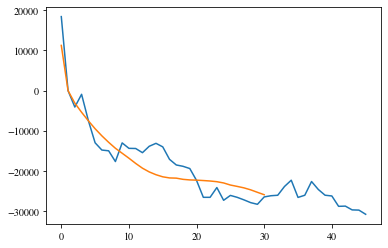

In [73]:
plt.plot(-9.8/1024*(VOLPV-VOLPV[1]))
# plt.plot(9.8/1024*(PV_VOL-PV_VOL[1]))
plt.plot(dsPV.pv_wc - dsPV.pv_wc[1])

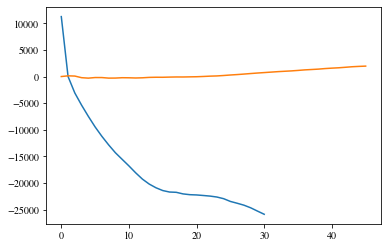

In [27]:
plt.plot(dsPV.pv_wc - dsPV.pv_wc[1])
plt.plot(adv_flux_i)

In [83]:
adv_flux_w = adv_flux_i

NameError: name 'adv_flux_i' is not defined